In [1]:
import csv
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/cleaned.csv')

In [3]:
models_df = pd.DataFrame(columns=['score_train','score_test','r2','MSE','RMSE'],
                         index=['Model_1_test','Model_2_test','Model_3_test','Model_4_test','Model_5_test'])

In [4]:
def all_the_metrics(model_name,score_1,y_t,y_p,score_2,y_t_test,y_p_test):
    models_df.loc[model_name+"_test",'score_train'] = score_1
    models_df.loc[model_name+"_test",'score_test'] = score_2
    models_df.loc[model_name+"_test",'r2'] = metrics.r2_score(y_t_test,y_p_test)
    models_df.loc[model_name+"_test",'MSE'] = metrics.mean_squared_error(y_t_test,y_p_test)
    models_df.loc[model_name+"_test",'RMSE'] = np.sqrt(metrics.mean_squared_error(y_t_test,y_p_test))

### All Numeric Models

I'm going to start with all the numeric columns (35 in total).

I'm first going to focus on 4 key steps in my pipe, using `GridSearchCV` to optimize for the best parameters:
1. Set a Variance Threshold (this drop any features who's variance throughout all the rows exceeds the threshold - in order to not only lower the number of input features, but also to drop features that would either have no effect, or negatively effect the model.)
2. StandardScale the data (this balances the weight of numeric data, so that a 1 unit increase in square-footage can be related to a 1 unit increase in bedrooms.)
3. SelectKBest features (this chooses x_best number of features that have the strongest impact on the model)
4. Run LinearRegression (this calculates values for each weight, and solves a series of equations to produce a linear model)

*Note*: To ensure readability of these models, I have turned `verbose` to `0` when running `GridSearchCV` for the final submission. However, in my testing, I kept it on, and made sure to look at `model.best_estimator_` so that I could effectively refine the model towards its peak performance. So each step, with fine tuned adjustments, is a result of building off of `model.best_estimator_` to best tune the hyperparameters.

In [5]:
lr = LinearRegression()

num_features = list(df.select_dtypes(exclude='object').columns)[3:31]
X = df[num_features]
y = df['SalePrice_deskewed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
steps = [
    ("var_thres", VarianceThreshold()),
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest(score_func=f_regression)),
    ("lr", LinearRegression())
]

pipe = Pipeline(steps)

In [7]:
def run_model(param_grid,name):
    gs = GridSearchCV(pipe,param_grid,verbose=0,cv=3,return_train_score=True,n_jobs=3)
    model = gs.fit(X_train,y_train)
    all_the_metrics(name,model.score(X_train,y_train),y_train,model.predict(X_train),
                    model.score(X_test,y_test),y_test,model.predict(X_test))
    
#     with open('../assets/'+name+'_numericonly_pipe.pkl', 'wb+') as f:
#         pickle.dump(model, f)
        
#     print(model.best_estimator_, model.best_score_)

In [8]:
param_grid = {
    "var_thres__threshold":[.1,.2,.8,.9],
    "kbest__k": [3,7,13]
}

run_model(param_grid,"Model_1")

In [9]:
param_grid = {
    "var_thres__threshold":[0.0,.05,.15,],
    "kbest__k": [11,13,21]
}

run_model(param_grid,"Model_2")

**This is great. I found that having a Variance Threshold of `0.0` is best, and I should aim for higher number of features with KBest.**

In [10]:
param_grid = {
    "kbest__k": [25,26,27]
}

run_model(param_grid,"Model_3")

**27 features seems like a sweet spot.** — This is odd because very few (if any) features have been dropped.

I'll quickly look at how well the predicted values faired against the true values.

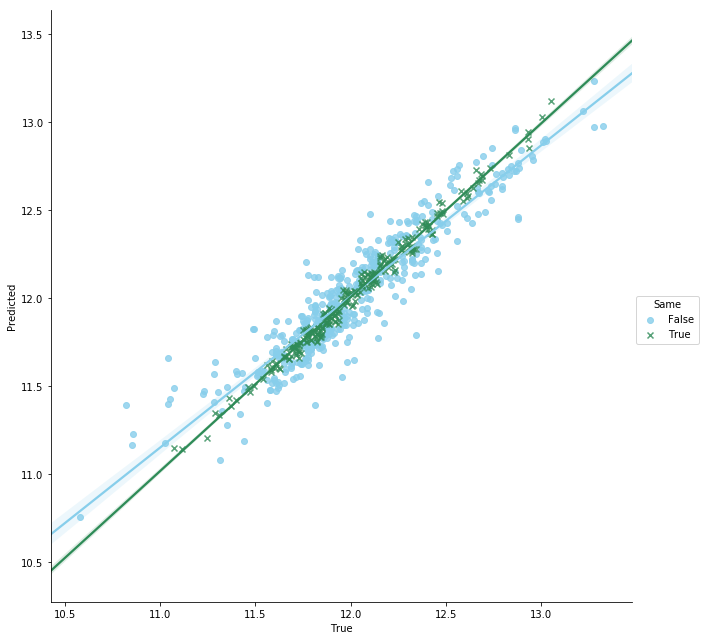

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train,y_train)
X_test_ss = ss.transform(X_test)

kbest = SelectKBest(k=27)
X_train_kb = kbest.fit_transform(X_train_ss,y_train)
X_test_kb = kbest.transform(X_test_ss)

lr = LinearRegression()
lr.fit(X_train_kb,y_train)

lr_predict_df = pd.DataFrame({'True':y_test,
                           'Predicted':lr.predict(X_test_kb),
                           'Same':(np.round(y_test,1) == np.round(lr.predict(X_test_kb),1))})

sns.lmplot(x='True',y='Predicted',data=lr_predict_df,size=9, aspect=1,hue='Same',
           markers=["o", "x"],palette={True:"seagreen", False:"skyblue"});

**Not bad! However, I'm going to compare that to ElasticNetCV, since it'll lower certain coefficients to 0, and only allow me to focus on those coefficients that matter the most.**

But since I have that too at my disposal, I'll couple it with PolynomialFeatures before so that I can find any interaction variables that do matter and can disregard the others. I'm first going to focus on 3 key steps in my pipe:
1. Create PolynomialFeatures (this creates interaction variables between features. instead of just having bedrooms and bathrooms, it produces another feature called bedrooms x bathrooms which allows me greater insight into how features work together in the end model.) 
2. StandardScale the data
3. Run ElasticNetCV (this implements a combo of Ridge and Lasso regularization. While Ridge simply lowers the strength of each feature, Lasso prioritizes 0-ing out features completely. I'll need to find what `l1_ratio` [this refers to "how" Ridge or Lasso it is] provides the best results)

In [12]:
steps = [
    ("poly", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("encv", ElasticNetCV(random_state=42))
]

pipe = Pipeline(steps)

In [13]:
param_grid = {
    "encv__cv": [3,7,11],
    "encv__l1_ratio": [.05,.25,.5,.75,.95]
}

run_model(param_grid,"Model_4")

In [14]:
param_grid = {
    "encv__cv": [3],
    "encv__l1_ratio": [.05,.1,.15,.2]
}

run_model(param_grid,"Model_5")

In [15]:
models_df.sort_values("score_test")

,score_train,score_test,r2,MSE,RMSE
Model_1_test,0.885058,0.87557,0.87557,0.0188787,0.1374
Model_2_test,0.89509,0.886847,0.886847,0.0171678,0.131026
Model_3_test,0.909206,0.89979,0.89979,0.015204,0.123305
Model_5_test,0.91688,0.901049,0.901049,0.0150131,0.122528
Model_4_test,0.916598,0.90135,0.90135,0.0149674,0.122341


### Understanding the model!

**This is a very good sign. After every iteration I've gone through, the model does better and better every single time. There haven't been any drops in improvement.**

I'm going to recreate that model, and:
1. Compare True vs. Predicted Values
2. Look at features with the strongest weight

In [16]:
poly = PolynomialFeatures(interaction_only=True)
X_train_p = poly.fit_transform(X_train,y_train)
X_test_p = poly.transform(X_test)

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_p,y_train)
X_test_ss = ss.transform(X_test_p)

encv = ElasticNetCV(cv=3,l1_ratio=.1)
encv.fit(X_train_ss,y_train)

encv_coefs = pd.DataFrame({'Var':poly.get_feature_names(list(df.select_dtypes(exclude='object').columns)[3:31]),
                           "Coef":encv.coef_})

In [17]:
encv_predict_df = pd.DataFrame({'True':y_test,
                           'Predicted':encv.predict(X_test_ss),
                           'Same':(np.round(y_test,1) == np.round(encv.predict(X_test_ss),1))})

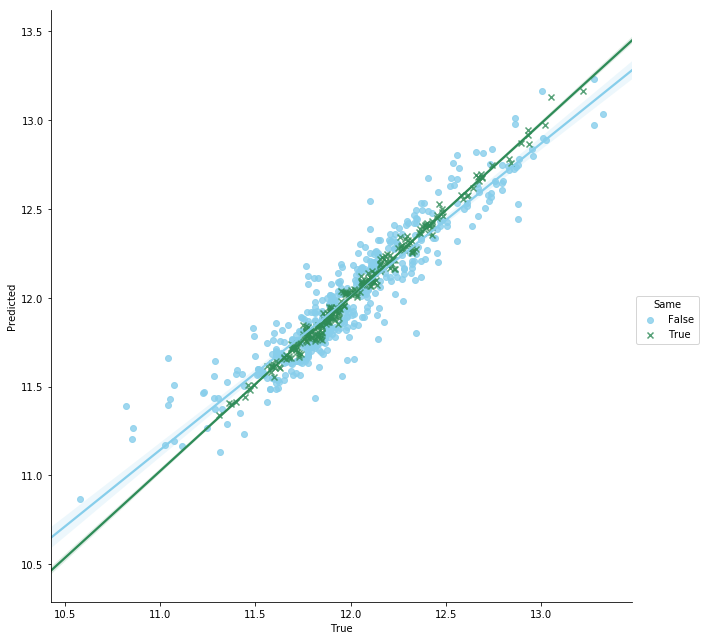

In [18]:
sns.lmplot(x='True',y='Predicted',data=encv_predict_df,size=9, aspect=1,hue='Same',
           markers=["o", "x"],palette={True:"seagreen", False:"skyblue"});

**This clearly shows that my predicted values are very comparable to the true values.**

Now I want to delve deeper into which interaction variables have the highest impact.

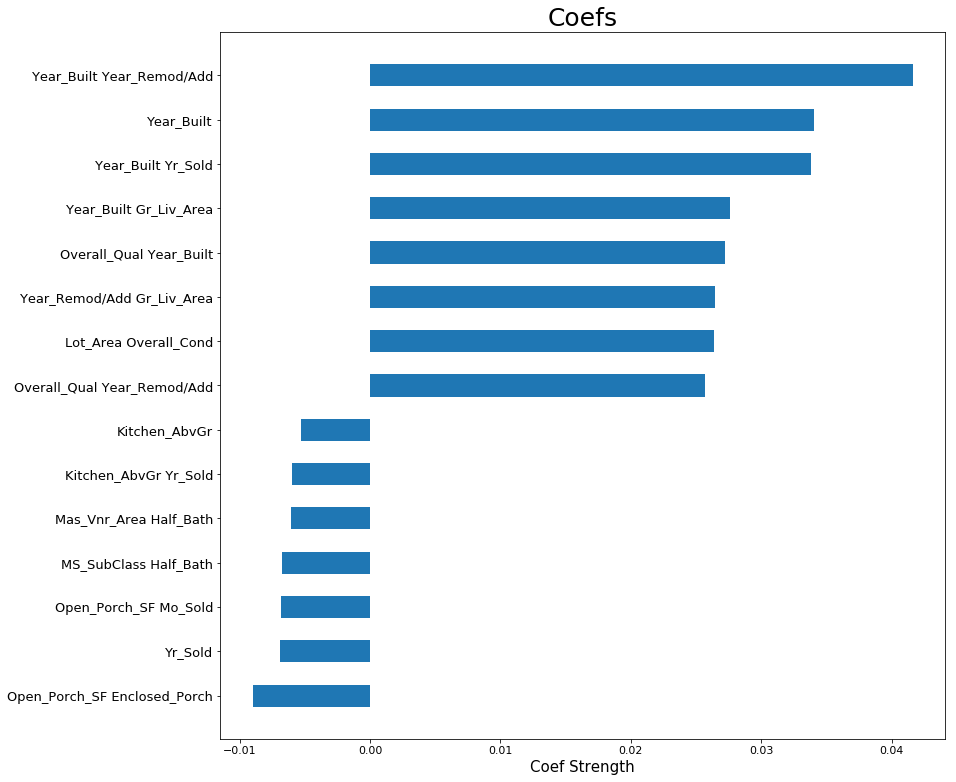

In [19]:
a = encv_coefs[(encv_coefs['Coef'] > .025) | (encv_coefs['Coef'] < -.005)].sort_values('Coef')['Coef']
b = encv_coefs[(encv_coefs['Coef'] > .025) | (encv_coefs['Coef'] < -.005)].sort_values('Coef')['Var']

N = len(a)
ind = np.arange(N)
width= .5

plt.barh(ind, a, width)

plt.xlabel('Coef Strength',fontsize=15)
plt.title('Coefs',fontsize=25)
plt.yticks(ind, b,fontsize=13)

plt.xticks(np.arange(-.01, .05, .01),fontsize=11)

a = plt.gcf()
a.set_size_inches(13, 13)

plt.show()

**This is very good to know. The `Year` and `Size` have the largest impact. And that makes sense. However, I want to know which** *upgradeable* **features have the greatest impact on price. That way, when I buy an undervalued house — even if it isn't nice — I know exactly which features to focus on an upgrade.**

At the same time, `Mo_Sold` and `Yr_Sold` have a negative impact. That's probably because of the dip in the market in 2008/2009.

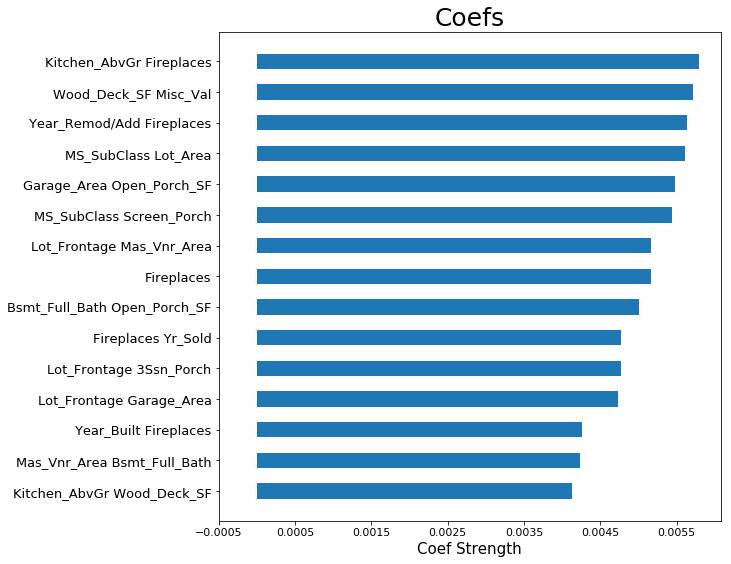

In [20]:
a = encv_coefs[((encv_coefs['Coef'] < .0063) & (encv_coefs['Coef'] > .0035))].sort_values('Coef')['Coef']
b = encv_coefs[((encv_coefs['Coef'] < .0063) & (encv_coefs['Coef'] > .0035))].sort_values('Coef')['Var']

N = len(a)
ind = np.arange(N)
width= .5

plt.barh(ind, a, width)

plt.xlabel('Coef Strength',fontsize=15)
plt.title('Coefs',fontsize=25)
plt.yticks(ind, b,fontsize=13)

plt.xticks(np.arange(-0.0005, .0065, .001),fontsize=11)

a = plt.gcf()
a.set_size_inches(9, 9)

plt.show()

**Sadly, this doesn't give me much more information. Since all these top values, even after moving away from those with `Year`, are still heavily impacted by square-footage. In the next notebook, I'll use both numeric and categorical data.**